In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import sklearn.decomposition
import h5py
import seaborn as sns
import scipy.sparse

In [2]:
zm_data = dict()

## Load zero-meaned data from sarah (from subspace_preprocess_thijs nb)
zm_data['sarah'] = dict()

cwd = os.getcwd()
os.chdir('/home/thijs/Google Drive/oxford/packerlab/data_sarah')
hfile = h5py.File('data_sarah_s1s2_zero_mean_2019-07-24_RL042_B2_2P_t003.h5', 'r')  # open with read access
for key in hfile.keys():
    try:
        zm_data['sarah'][key] = np.array(hfile[key][()], dtype=np.float32)
    except ValueError: # cannot be converted to float, because it is e.g. the name str
        pass
os.chdir(cwd)
print(f'Keys of zero-mean sarah data: {zm_data["sarah"].keys()}')
hfile.close()

Keys of zero-mean sarah data: dict_keys(['dff_s1', 'dff_s1_mean', 'dff_s2', 'dff_s2_mean', 'spikes_s1', 'spikes_s1_mean', 'spikes_s2', 'spikes_s2_mean'])


In [3]:
## Load zero-meaned data from semedo ea (from matlab preprocessing file)
cwd = os.getcwd()
os.chdir('/home/thijs/Google Drive/oxford/packerlab/data_semedo/v1-v2_gratings/h5_data')
hfile = h5py.File('data_semedo_v1v2_zero_mean.h5', 'r')  # open with read access

dict_names_samples = {'107l002p67': 'm1',
                      '107l003p143': 'm2',
                      '106r001p26': 'm3',
                      '105l001p16': 'm4',
                      '106r002p70': 'm5'}

def load_semedo_data(data_path, obj):
    if isinstance(obj, h5py.Dataset):  # if object is a dataset
        ## Currenty hard-coded identities, identify from data path:
        sample = data_path.split('/')[0]
        stimulus = data_path.split('/')[1]
        type_region = data_path.split('/')[2]
        
        name_dataset = 'semedo_' + dict_names_samples[sample] + '_st' + stimulus[-1]  # name for this data set (per sample and stimulus)
        if name_dataset not in zm_data.keys():  # create entry if necessary
            zm_data[name_dataset] = dict()
        
        zm_data[name_dataset][type_region] = np.array(obj[()], dtype=np.float32)  # load data
        
        # Note that if you load indices, they are 1-indexed!!! (matlab-style) so they should be corrected:
        if type_region[-7:] == 'indices':
            zm_data[name_dataset][type_region] -= 1
        
hfile.visititems(load_semedo_data)  # visit all items in h5 file recursively and call function
    
os.chdir(cwd)
print(f'Keys of zero-mean semedo data: {zm_data["semedo_m2_st5"].keys()}')
hfile.close()

Keys of zero-mean semedo data: dict_keys(['spikes_v1', 'spikes_v1_indices', 'spikes_v1_mean', 'spikes_v2', 'spikes_v2_indices', 'spikes_v2_mean'])


## Inspect data

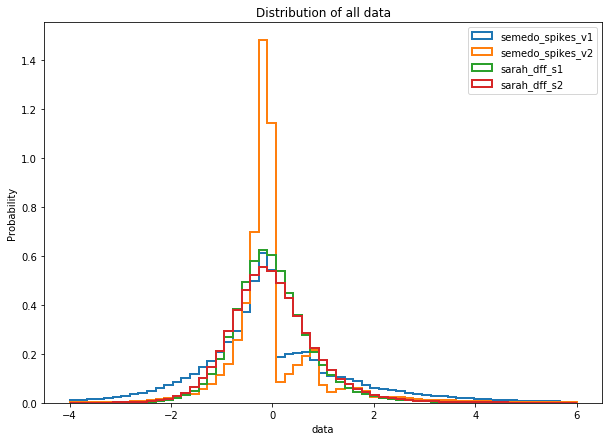

In [4]:
plt.rcParams['figure.figsize'] = (10, 7)

for data_name in ['spikes_v1', 'spikes_v2']:
    tmp_semedo_hist_data = np.array([])
    for x in zm_data.keys():
        if 'semedo_' in x:
            tmp_semedo_hist_data = np.concatenate((tmp_semedo_hist_data, 
                                                   zm_data[x][data_name].reshape(-1)))
    plt.hist(tmp_semedo_hist_data / 1, histtype='step', linewidth=2,
             bins=np.linspace(-4, 6, 60), density=True, label='semedo_' + data_name);
for data_name in ['dff_s1', 'dff_s2']:
    plt.hist(zm_data['sarah'][data_name].reshape(-1), histtype='step', linewidth=2,
             bins=np.linspace(-4, 6, 60), density=True, label='sarah_' + data_name);
    
plt.legend()
plt.title('Distribution of all data'); plt.xlabel('data'); plt.ylabel('Probability');

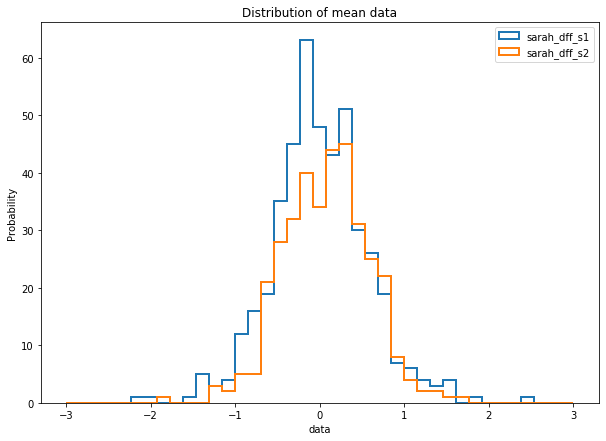

In [5]:
### plt.rcParams['figure.figsize'] = (10, 7)

metric_plot = 'mean'

if metric_plot == 'std':
    for data_name in ['spikes_v1', 'spikes_v2']:
        plt.hist(zm_data['semedo'][data_name].std(1) / 1, histtype='step', linewidth=2,
                 bins=np.linspace(0, 4, 20), density=True, label='semedo_' + data_name);
    for data_name in ['dff_s1', 'dff_s2']:
        plt.hist(zm_data['sarah'][data_name].std(1), histtype='step', linewidth=2,
                 bins=np.linspace(0, 4, 20), density=True, label='sarah_' + data_name);

elif metric_plot == 'mean':
    plot_bins = np.linspace(-3, 3, 40)
#     for data_name in ['spikes_v1', 'spikes_v2']:
#         plt.hist(zm_data['semedo'][data_name + '_mean'].sum(1) / 1, histtype='step', linewidth=2,
#                  bins=plot_bins, density=False, label='semedo_' + data_name);
    for data_name in ['dff_s1', 'dff_s2']:
        plt.hist((zm_data['sarah'][data_name + '_mean']).sum(1), histtype='step', linewidth=2,
                 bins=plot_bins, density=False, label='sarah_' + data_name);

plt.legend()
plt.title(f'Distribution of {metric_plot} data'); plt.xlabel('data'); plt.ylabel('Probability');

# Define source and target populations

In [6]:
## TODO: do fancy FR-corrected random sampling

source = {}
target = {}
n_source = {}
n_target = {}

def add_to_source_target(data_or, name_1, name_2, bin_size=None,
                         select_method='random', min_st1_ratio=0.7):
    """
    
    Arguments:
        data_or: str
            data origin name 
        name_1: str 
            name of first data set (eg spikes_s1)
        name_2: str
            name of second data set
        bin_size: float = None (-> will be defined in code)
            size of bin for FR correcti
        min_st1_ratio:float = 0.7
            minimum factor of source neurons
        select_method: str
            'random' for unbiased random selection of 1 target, 'fr-corr' for firing rate corrected.
    """
    
    n_v1 = zm_data[data_or][name_1].shape[0]
    n_v2 = zm_data[data_or][name_2].shape[0]
    if select_method == 'random':
        n_v1_s = np.maximum(n_v1 - n_v2, int(np.round(0.7 * n_v1)))
        n_v1_t = n_v1 - n_v1_s
        inds_v1_s = np.random.choice(a=n_v1, size=n_v1_s, replace=False)
        inds_v1_t = np.array(list(set(np.arange(n_v1)).difference(set(inds_v1_s))))
        inds_v2_t = np.arange(n_v2)
        
    elif select_method == 'fr-corr':
        inds_v1_s, inds_v1_t, inds_v2_t = np.array([]), np.array([]), np.array([])  # initiate empty indices
        
        if data_or[:6] == 'semedo':
            if bin_size is None:
                bin_size = 5
            freq = 10
        elif data_or[:5] == 'sarah':
            if name_1[:3] == 'dff' and name_2[:3] == 'dff':
                if bin_size is None:
                    bin_size = 1
                freq = 11.5  # hard-coded, from preprocessing nb
            
        means_1 = zm_data[data_or][name_1 + '_mean'].mean(1) * freq  # go to Hz
        means_2 = zm_data[data_or][name_2 + '_mean'].mean(1) * freq
        if data_or[:6] == 'semedo':
            bin_max = np.ceil(np.maximum(np.max(means_1), np.max(means_2)) 
                              / bin_size) * bin_size  # get max bin with interval bin_size
            bin_min = 0
        elif data_or[:5] == 'sarah':
            bin_max = 5    
            bin_min = np.floor(np.minimum(np.min(means_1), np.min(means_2)) 
                              / bin_size) * bin_size  # get max bin with interval bin_size
        hist_bins = np.linspace(bin_min, bin_max, int((bin_max - bin_min) / bin_size + 1))  # make bin edges
        
        count_1, bin_edges = np.histogram(means_1, bins=hist_bins)  # compute histogram for both
        count_2, bin_edges = np.histogram(means_2, bins=hist_bins)
        
        def add_indices(bin_low, bin_high, sample_size):
            all_inds_1 = np.where(np.logical_and(means_1 < bin_high, means_1 >= bin_low))[0]  # find indices in this bin
            sampled_inds_1 = np.random.choice(a=all_inds_1, size=sample_size, replace=False)  # sample target pop from these
            
            all_inds_2 = np.where(np.logical_and(means_2 < bin_high, means_2 >= bin_low))[0]
            sampled_inds_2 = np.random.choice(a=all_inds_2, size=sample_size, replace=False)
            
            sampled_inds_s = np.array(list(set(all_inds_1).difference(set(sampled_inds_1))))
            
            return sampled_inds_1, sampled_inds_2, sampled_inds_s
        
        for i_bin, low_bin in enumerate(bin_edges[:-1]):  # loop through bins
            t_size = np.minimum(count_1[i_bin], count_2[i_bin])  # minimum determines target size (semedo ea)
            if data_or[:5] == 'sarah':
                t_size = int(t_size * 0.4) ## NB: hard-coded change to decrease target size of sarah's data set ( to align with semedo's)
            tmp_1t, tmp_2t, tmp_s = add_indices(bin_low=low_bin, bin_high=bin_edges[i_bin + 1], sample_size=t_size)
            assert len(tmp_1t) == len(tmp_2t)
            inds_v1_t = np.concatenate((inds_v1_t, tmp_1t))  # add to current indices
            inds_v2_t = np.concatenate((inds_v2_t, tmp_2t))
            inds_v1_s = np.concatenate((inds_v1_s, tmp_s))
        
        ## Now we'll pool all data > bin_max
        all_inds_1 = np.where(means_1 >= bin_edges[-1])[0]
        all_inds_2 = np.where(means_2 >= bin_edges[-1])[0]
        t_size = np.minimum(len(all_inds_1), len(all_inds_2))
        
        tmp_1t, tmp_2t, tmp_s = add_indices(bin_low=bin_edges[-1], bin_high=1e6, sample_size=t_size)
        inds_v1_t = np.concatenate((inds_v1_t, tmp_1t))
        inds_v2_t = np.concatenate((inds_v2_t, tmp_2t))
        inds_v1_s = np.concatenate((inds_v1_s, tmp_s))
        
        assert len(inds_v1_t) == len(inds_v2_t)
        n_v1_s = len(inds_v1_s)
        n_v1_t = len(inds_v1_t)
    
    inds_v1_s = inds_v1_s.astype(int)
    inds_v1_t, inds_v2_t = inds_v1_t.astype(int), inds_v2_t.astype(int)
    source[data_or] = zm_data[data_or][name_1][inds_v1_s, :]
    target[data_or] = {}
    target[data_or]['1'] = zm_data[data_or][name_1][inds_v1_t, :]
    target[data_or]['2'] = zm_data[data_or][name_2][inds_v2_t, :]
    n_source[data_or] = n_v1_s
    n_target[data_or] = n_v1_t
    return inds_v1_s, inds_v1_t, inds_v2_t
    
zm_data['semedo'] = zm_data['semedo_m1_st4']
tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or='semedo', name_1='spikes_v1', 
                                             name_2='spikes_v2', select_method='fr-corr')

tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or='sarah', name_1='dff_s1', 
                                             name_2='dff_s2', select_method='fr-corr')

print(target['sarah']['2'].shape)

(141, 2300)


## Correlations
Recreate fig 2A from Semedo ea (merge the top and bottom panel), per data set

Note: Inferring from the number of pairs in fig 2A, it seems that they pooled all stimuli (as opposed to the rest of the paper). So these are all pairs from 5 data sets (instead of 40). It will take quite some adjustment to make my code compatible with this (incl FR-corrected splitting). But as results seem ok per stimulus (instead of across stimuli), I'll leave it be.

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


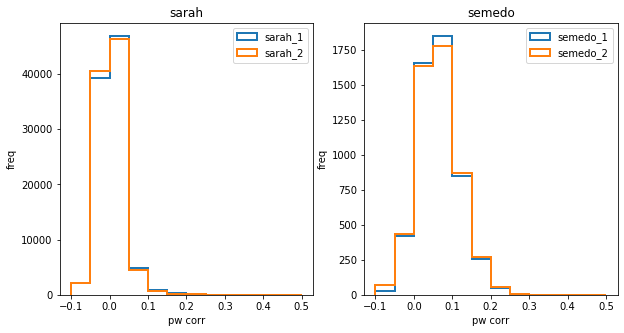

In [7]:
def correlation_matrix(sdata, tdata):
    assert sdata.shape[1] == tdata.shape[1]
    corr_mat = np.corrcoef(sdata, tdata)  # use np to compute full correlation matrix
    return corr_mat

plt.rcParams['figure.figsize'] = (10, 5)
for i_data, data_or in enumerate(['sarah', 'semedo']):
    for tname in ['1', '2']:
        cmat = correlation_matrix(sdata= source[data_or], 
                                         tdata=target[data_or][tname])
        cmat = cmat[:n_source[data_or], n_target[data_or]:]  # only select interactions between s and t
        plt.subplot(1, 2, i_data + 1)
        plt.hist(cmat.reshape(-1), histtype='step', linewidth=2, 
                 bins=np.linspace(-0.1, 0.5, 13), label=data_or + '_' + tname)
    plt.legend(); plt.title(data_or); plt.xlabel('pw corr'); plt.ylabel('freq');

## Regress target versus source
Recreate fig 2B (merged). Only look at multivar regression (and not the single neuron case).

In [8]:
def multivar_regression(sdata, tdata, n_cv=5, delta_t=0):
    """Perform multivar regression and assess R2 of test data
    
    Arguments:
    ----------------
        sdata: np.array
            source data (n_cells_s x n_times)
        tdata: np.array
            target dtaa (n_cells_t x n_times)
        n_cv: int = 5
            number of cv folds
        delta_t: int = 1
            how many time steps to predict into the future 
    
    Returns:
    -------------------
        model: sklearn.linear_model.LinearRegression
            full regression model 
        r2_test: np.array
            1D array of r2 per target neuron
    """
    
    assert sdata.shape[1] == tdata.shape[1]
    n_total = tdata.shape[1]  # number of time points
    
    if delta_t == 0:
        kf = sklearn.model_selection.KFold(n_splits=n_cv)
        alpha_array = np.logspace(-2, 7, 10)
        r2_test_kf = np.zeros((len(alpha_array), n_cv))
        
        for i_alpha, alpha_param in enumerate(alpha_array):
            i_kf = 0
            for train_inds, test_inds in kf.split(np.arange(n_total)):
    #             model = sklearn.linear_model.LinearRegression()
                model = sklearn.linear_model.Ridge(alpha=alpha_param)
    #             model = sklearn.linear_model.Lasso(alpha=0.1)
                model.fit(X=sdata[:, train_inds].T, y=tdata[:, train_inds].T)  # fit to train data
                pred_tdata = model.predict(X=sdata[:, test_inds].T)  # predict traces for test data set
                r2_test_kf[i_alpha, i_kf] = sklearn.metrics.r2_score(y_true=tdata[:, test_inds].T, y_pred=pred_tdata,
                                              multioutput='variance_weighted')
                i_kf += 1
        r2_alpha = np.mean(r2_test_kf, 1)
#         print(alpha_array[np.argmax(r2_alpha)], np.max(r2_alpha))
#         print(r2_alpha)
        r2_test = np.max(r2_alpha)
    else:    
        n_train = int(np.round((n_cv - 1) / n_cv * tdata.shape[1]))  # use first section for training -> bias?
        model = sklearn.linear_model.LinearRegression()
        model.fit(X=sdata[:, :int(n_train - delta_t)].T, y=tdata[:, delta_t:n_train].T)  # fit to train data
        pred_tdata = model.predict(X=sdata[:, n_train:(n_total - delta_t)].T)  # predict traces for test data set
        sst = np.power((pred_tdata.T - tdata[:, (n_train + delta_t):]), 2).sum(1)  # total error squared
        mse = np.power((tdata[:, (n_train + delta_t):] -
                        tdata[:, (n_train + delta_t):].mean(1)[:, np.newaxis]), 2).sum(1)  # mean squared error
        r2_test = 1 - sst/mse
    return model, r2_test

class ReducedRankRegressor(object):
    """
    
    https://github.com/riscy/machine_learning_linear_models/blob/master/reduced_rank_regressor.py
    
    Reduced Rank Regressor (linear 'bottlenecking' or 'multitask learning')
    - X is an n-by-d matrix of features.
    - Y is an n-by-D matrix of targets.
    - rrank is a rank constraint.
    - reg is a regularization parameter (optional).
    """
    def __init__(self, X, Y, rank, reg=None):
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        if np.size(np.shape(Y)) == 1:
            Y = np.reshape(Y, (-1, 1))
        if reg is None:
            reg = 0
        self.rank = rank

        CXX = np.dot(X.T, X) + reg * scipy.sparse.eye(np.size(X, 1))
        CXY = np.dot(X.T, Y)
        _U, _S, V = np.linalg.svd(np.dot(CXY.T, np.dot(np.linalg.pinv(CXX), CXY)))
        self.W = V[0:rank, :].T
        self.A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, self.W)).T

    def __str__(self):
        return 'Reduced Rank Regressor (rank = {})'.format(self.rank)

    def predict(self, X):
        """Predict Y from X."""
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        return np.dot(X, np.dot(self.A.T, self.W.T))

def red_rank_regression(sdata, tdata, rank=5, n_cv=5):
    assert sdata.shape[1] == tdata.shape[1]
    n_total = tdata.shape[1]  # number of time points
    kf = sklearn.model_selection.KFold(n_splits=n_cv)
    r2_test_kf = np.zeros((n_cv))
    i_kf = 0
    for train_inds, test_inds in kf.split(np.arange(n_total)):
        n_train = len(train_inds)
        model = ReducedRankRegressor(X=sdata[:, train_inds].T, Y=tdata[:, train_inds].T,
                                    rank=rank, reg=None)
        pred_tdata = model.predict(X=sdata[:, test_inds].T)  # predict traces for test data set
        r2_test_kf[i_kf] = sklearn.metrics.r2_score(y_true=tdata[:, test_inds].T, y_pred=pred_tdata,
                                          multioutput='variance_weighted')
        i_kf += 1
    r2_test = np.mean(r2_test_kf, 0)
    return model, r2_test

In [9]:
source, target = {}, {}
    
tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or='semedo', name_1='spikes_v1', 
                                             name_2='spikes_v2', select_method='fr-corr')

tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or='sarah', name_1='dff_s1', 
                                             name_2='dff_s2', select_method='fr-corr')
color_plot = {'1': 'b', '2': 'r'}
t_list = ['1', '2']
av_r2_sarah = {}
plt.rcParams['figure.figsize'] = (6, 6)
for i_data, data_or in enumerate(['sarah']):
    for tname in t_list:
        
        
        _, r2 = multivar_regression(sdata= source[data_or],# rank=3,
                                   tdata=target[data_or][tname])
        print(f'Data {data_or} {tname}, mean r2 {np.mean(r2)}')
        if data_or == 'sarah':
            av_r2_sarah[tname] = np.mean(r2)
#         plt.subplot(2, 2, i_data + 1)
#         plt.hist(r2.reshape(-1), histtype='step', linewidth=2, 
#                  label=data_or + '_' + tname)
#     plt.legend(); plt.title(data_or); plt.xlabel('R2'); plt.ylabel('freq');
    
    
av_r2_semedo = {x: np.zeros(40) for x in t_list} # 40 = 5 samples x 8 stimuli (semedo ea)
n_runs = 25
i_ds = 0
for m_index in tqdm(range(1, 6)):
    for st_index in range(1, 9):
        r2_runs = {x: np.zeros(n_runs) for x in t_list}
        for i_run in range(n_runs):
            source, target = {}, {}
            zm_name = f'semedo_m{m_index}_st{st_index}'
            tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or=zm_name, name_1='spikes_v1', 
                                                         bin_size=None,
                                                 name_2='spikes_v2', select_method='fr-corr')
            for tname in t_list:
                r2_runs[tname][i_run] = np.mean(
                    multivar_regression(sdata= source[zm_name], n_cv=5,
                                            tdata=target[zm_name][tname])[1])
            
        for tname in t_list:
            av_r2_semedo[tname][i_ds] = np.mean(r2_runs[tname])
        i_ds += 1
        

Data sarah 1, mean r2 0.010664357405891806


  0%|          | 0/5 [00:00<?, ?it/s]

Data sarah 2, mean r2 -0.014161471514195278


100%|██████████| 5/5 [06:55<00:00, 83.02s/it]


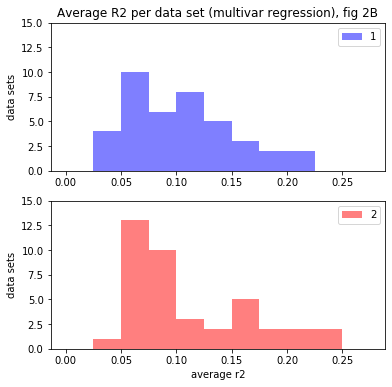

In [10]:
color_plot = {'1': 'b', '2': 'r'}
for i_plot, tname in enumerate(t_list):
    plt.subplot(2, 1, i_plot + 1)
    plt.hist(av_r2_semedo[tname], histtype='stepfilled', label=tname, 
             alpha=0.5, linewidth=3, color=color_plot[str(int(i_plot + 1))],
             bins=np.arange(np.minimum(np.nanmin(av_r2_semedo[tname]), 0), 
                            np.maximum(np.nanmax(av_r2_semedo[tname]), 0.3), 0.025)) 
            
    plt.ylim([0, 15])
    if i_plot == 0:
        plt.title('Average R2 per data set (multivar regression), fig 2B')
    else:
        plt.xlabel('average r2'); 
    plt.ylabel('data sets'); plt.legend();
    

In [11]:

try:
    del zm_data['semedo']
except KeyError:
    pass

semedo_name_list = [x for x in zm_data.keys() if x[:4] == 'seme']
n_semedo_ds = len(semedo_name_list)
n_runs = 25
n_ranks = 8
r2_semedo_ds = {'1': np.zeros((n_ranks, n_runs, n_semedo_ds)),
                '2': np.zeros((n_ranks, n_runs, n_semedo_ds))}

for run in tqdm(range(n_runs)):   
    for i_data, data_orig in enumerate(semedo_name_list): 
   
        source,target = {}, {}
        tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or=data_orig, name_1='spikes_v1', 
                                             name_2='spikes_v2', select_method='fr-corr')
        for rrank in range(n_ranks):
            for ttarget in ['1', '2']:
                 r2_semedo_ds[ttarget][rrank, run, i_data] = np.mean(red_rank_regression(sdata=source[data_orig], 
                                                                    rank=rrank,
                                                                    tdata=target[data_orig][ttarget])[1])
data_orig = 'sarah'
r2_sarah = {'1': np.zeros((n_ranks, n_runs)), 
            '2': np.zeros((n_ranks, n_runs))}
for run in range(n_runs):
    source,target = {}, {}
    tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or=data_orig, name_1='dff_s1', 
                                         name_2='dff_s2', select_method='fr-corr')
    for rrank in range(n_ranks):
        for ttarget in ['1', '2']:
             r2_sarah[ttarget][rrank, run] = np.mean(red_rank_regression(sdata=source[data_orig], 
                                                                rank=rrank,
                                                                tdata=target[data_orig][ttarget])[1])


100%|██████████| 25/25 [08:16<00:00, 19.87s/it]


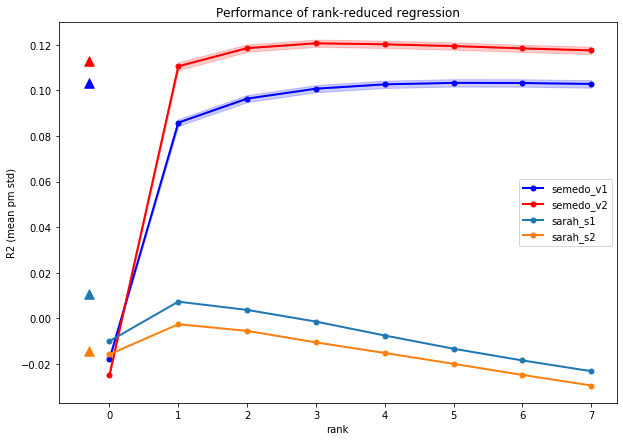

In [12]:
color_plot = {'1': 'b', '2': 'r'}
plt.rcParams['figure.figsize'] = (10, 7)
for ttarget in ['1', '2']:
    plt.plot(np.mean(r2_semedo_ds[ttarget], (1, 2)),'.-', linewidth=2, 
             c=color_plot[ttarget],markersize=10, label='semedo_v' + ttarget)
    
    plt.fill_between(x=np.arange(n_ranks), y1=np.mean(r2_semedo_ds[ttarget], (1, 2)), 
                     y2=(np.mean(r2_semedo_ds[ttarget], (1, 2)) + 
                         (np.std(r2_semedo_ds[ttarget], (1, 2)) / np.sqrt(n_runs * n_semedo_ds))), 
                     color=color_plot[ttarget], alpha=0.2)
    
    plt.fill_between(x=np.arange(n_ranks), y1=np.mean(r2_semedo_ds[ttarget], (1, 2)), 
                     y2=(np.mean(r2_semedo_ds[ttarget], (1, 2)) - 
                         (np.std(r2_semedo_ds[ttarget], (1, 2)) / np.sqrt(n_runs * n_semedo_ds))), 
                     color=color_plot[ttarget], alpha=0.2)
    plt.scatter(-0.3, av_r2_semedo[ttarget].mean(), c=color_plot[ttarget], marker='^', s=90)
#     plt.text(-0.4, av_r2_semedo[ttarget].mean() - 0.01, 'Full Model', c=color_plot[ttarget])
for ttarget in ['1', '2']:
    plt.plot(np.mean(r2_sarah[ttarget], 1), '.-', linewidth=2,
             markersize=10, label='sarah_s' + ttarget)
    plt.scatter(-0.3, av_r2_sarah[ttarget].mean(), marker='^', s=90)

plt.legend(); plt.xlabel('rank'); plt.ylabel('R2 (mean pm std)'); plt.title('Performance of rank-reduced regression');
# plt.xlim([0.5, 7])
# plt.ylim([0.08, 0.14])



### Difference with paper -> 
I tried std(datasets=mean(runs)) -> large std, and sem(runs=mean(datasets)) -> near-zero std.The final means are equivalent though.
### Discrepancy between FM-RRM for Sem1 and Sem2. (Slightly higher Sem2 might be due to overfitting? 
### Poor performance Sarah's data -> FR-corr? check by hand

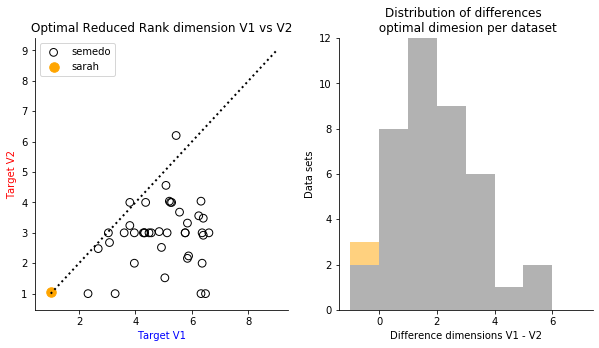

In [13]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplot(121)
plt.plot([1, 9], [1, 9], ':', c='k', linewidth=2)
plt.scatter(np.mean(np.argmax(r2_semedo_ds['1'], 0), 0),
            np.mean(np.argmax(r2_semedo_ds['2'], 0), 0), 
            marker='o', facecolors='none', edgecolors='k', s=60, label='semedo')
plt.scatter(np.mean(np.argmax(r2_sarah['1'], 0), 0),
            np.mean(np.argmax(r2_sarah['2'], 0), 0), 
            marker='o', facecolors='orange', edgecolors='orange', s=90, label='sarah')
plt.legend(); 
plt.xlabel('Target V1', color=color_plot['1']); plt.ylabel('Target V2', color=color_plot['2']);
plt.title('Optimal Reduced Rank dimension V1 vs V2')

plt.subplot(122)
diff_dims = np.mean(np.argmax(r2_semedo_ds['1'], 0), 0) - np.mean(np.argmax(r2_semedo_ds['2'], 0), 0)
sem_hist = plt.hist(diff_dims, bins=np.linspace(-1, 7, 9),alpha=0.3, color='k')
plt.hist(np.mean(np.argmax(r2_sarah['1'], 0), 0) - np.mean(np.argmax(r2_sarah['2'], 0), 0),
         bins=np.linspace(-1, 7, 9), bottom=sem_hist[0],
                    alpha=0.5, color='orange')
plt.xlabel('Difference dimensions V1 - V2'); plt.ylabel('Data sets');
plt.title('Distribution of differences \n optimal dimesion per dataset');

sns.despine()

# Intrinsic dimensionality of target data sets:

In [14]:
try:
    del zm_data['semedo']
except KeyError:
    pass

semedo_name_list = [x for x in zm_data.keys() if x[:4] == 'seme']
n_semedo_ds = len(semedo_name_list)
n_components = 18
n_cv = 5
dim_semedo_fa = {'1': np.zeros((n_cv, n_components, n_semedo_ds)),
                '2': np.zeros((n_cv, n_components, n_semedo_ds))}

dim_semedo_pca = {'1': np.zeros((n_cv, n_semedo_ds)),
                  '2': np.zeros((n_cv, n_semedo_ds))}

for i_data, data_orig in tqdm(enumerate(semedo_name_list)): 

    source,target = {}, {}
    tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or=data_orig, name_1='spikes_v1', 
                                         name_2='spikes_v2', select_method='fr-corr')
    for ttarget in ['1', '2']:
        kf = sklearn.model_selection.KFold(n_splits=n_cv)
        i_kf = 0
        n_total = target[data_orig][ttarget].shape[1]
        for train_inds, test_inds in kf.split(np.arange(n_total)):

            # fit fa
            for i_comp, comp in enumerate(np.arange(1, n_components + 1)):
                fa = sklearn.decomposition.FactorAnalysis(n_components=comp)
                fa.fit(X=target[data_orig][ttarget][:, train_inds].T)
                dim_semedo_fa[ttarget][i_kf, i_comp, i_data] = fa.score(target[data_orig][ttarget][:, test_inds].T)
            
            m_fa = np.argmax(dim_semedo_fa[ttarget][i_kf, :, i_data]) + 1  # Change to one-indexing (because of n_comp loop)
            if m_fa > target[data_orig][ttarget].shape[0]:  # if more components than neurons, set to n-neurons
                m_fa = target[data_orig][ttarget].shape[0]
            fa = sklearn.decomposition.FactorAnalysis(n_components=m_fa)  # fit fa again
            fa.fit(X=target[data_orig][ttarget].T)  # use all data
            
            tmp_pca = sklearn.decomposition.PCA(n_components=m_fa)  # now decompose w/ pca
            tmp_pca.fit(X=fa.components_.T)  
            cum_explvar = np.cumsum(tmp_pca.explained_variance_ratio_)  # cumulative R2
            top_pca_components = np.where(cum_explvar >= 0.95)[0]  # find where > 95% R2
            if len(top_pca_components) == 0:  # if no where, take max
                m_pca = len(top_pca_components)
            else: # otherwise take min of > 95%
                m_pca = np.min(top_pca_components) + 1 # (zero-indexing)
            dim_semedo_pca[ttarget][i_kf, i_data] = m_pca
            
            i_kf +=  1
            

## TODO: put in function and unify semedo and sarah keys


dim_sarah_fa = {'1': np.zeros((n_cv, n_components)),
                '2': np.zeros((n_cv, n_components))}

dim_sarah_pca = {'1': np.zeros(n_cv),
                  '2': np.zeros(n_cv)}
data_orig = 'sarah'
source,target = {}, {}
tmp_s, tmp_t1, tmp_t2 = add_to_source_target(data_or=data_orig, name_1='dff_s1', 
                                     name_2='dff_s2', select_method='fr-corr')
for ttarget in ['1', '2']:
    kf = sklearn.model_selection.KFold(n_splits=n_cv)
    i_kf = 0
    n_total = target[data_orig][ttarget].shape[1]
    for train_inds, test_inds in kf.split(np.arange(n_total)):

        # fit fa
        for i_comp, comp in enumerate(np.arange(1, n_components + 1)):
            fa = sklearn.decomposition.FactorAnalysis(n_components=comp)
            fa.fit(X=target[data_orig][ttarget][:, train_inds].T)
            dim_sarah_fa[ttarget][i_kf, i_comp] = fa.score(target[data_orig][ttarget][:, test_inds].T)

        m_fa = np.argmax(dim_sarah_fa[ttarget][i_kf, :]) + 1  # Change to one-indexing (because of n_comp loop)
        if m_fa > target[data_orig][ttarget].shape[0]:  # if more components than neurons, set to n-neurons
            m_fa = target[data_orig][ttarget].shape[0]
        fa = sklearn.decomposition.FactorAnalysis(n_components=m_fa)  # fit fa again
        fa.fit(X=target[data_orig][ttarget].T)  # use all data

        tmp_pca = sklearn.decomposition.PCA(n_components=m_fa)  # now decompose w/ pca
        tmp_pca.fit(X=fa.components_.T)  
        cum_explvar = np.cumsum(tmp_pca.explained_variance_ratio_)  # cumulative R2
        top_pca_components = np.where(cum_explvar >= 0.95)[0]  # find where > 95% R2
        if len(top_pca_components) == 0:  # if no where, take max
            m_pca = len(top_pca_components)
        else: # otherwise take min of > 95%
            m_pca = np.min(top_pca_components) + 1 # (zero-indexing)
        dim_sarah_pca[ttarget][i_kf] = m_pca

        i_kf +=  1

40it [14:45, 22.13s/it]


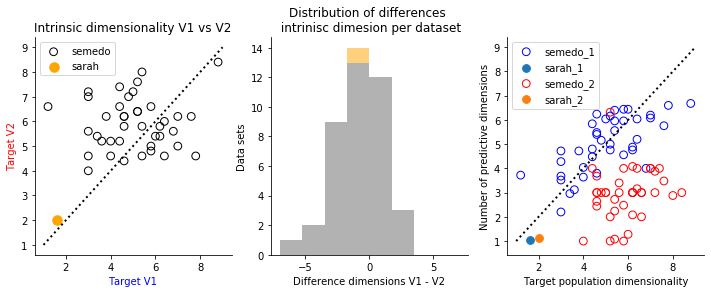

In [215]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(131)
plt.plot([1, 9], [1, 9], ':', c='k', linewidth=2)
plt.scatter(dim_semedo_pca['1'].mean(0),
            dim_semedo_pca['2'].mean(0), 
            marker='o', facecolors='none', edgecolors='k', s=60, label='semedo')
plt.scatter(dim_sarah_pca['1'].mean(0),
            dim_sarah_pca['2'].mean(0), 
            marker='o', facecolors='orange', edgecolors='orange', s=90, label='sarah')
plt.legend(); 
plt.xlabel('Target V1', color=color_plot['1']); plt.ylabel('Target V2', color=color_plot['2']);
plt.title('Intrinsic dimensionality V1 vs V2')

plt.subplot(132)
diff_dims = dim_semedo_pca['1'].mean(0) - dim_semedo_pca['2'].mean(0)
sem_hist = plt.hist(diff_dims, bins=np.linspace(-7, 7, 9),alpha=0.3, color='k')
plt.hist(dim_sarah_pca['1'].mean(0) - dim_sarah_pca['2'].mean(0),
         bins=np.linspace(-7, 7, 9), bottom=sem_hist[0],
                    alpha=0.5, color='orange')
plt.xlabel('Difference dimensions V1 - V2'); plt.ylabel('Data sets');
plt.title('Distribution of differences \n intrinisc dimesion per dataset');

plt.subplot(133)
plt.plot([1, 9], [1, 9], ':', c='k', linewidth=2)
for ttarget in ['1', '2']:
    plt.scatter(dim_semedo_pca[ttarget].mean(0),
            np.mean(np.argmax(r2_semedo_ds[ttarget], 0), 0), 
            marker='o', facecolors='none', edgecolors=color_plot[ttarget], s=60, label='semedo_' + ttarget)
    plt.scatter(dim_sarah_pca[ttarget].mean(0),
            np.mean(np.argmax(r2_sarah[ttarget], 0), 0), 
            marker='o', s=60, label='sarah_' + ttarget)

plt.xlabel('Target population dimensionality')
plt.ylabel('Number of predictive dimensions');
plt.legend()
sns.despine()